In [1]:
#The basics
import pandas as pd
import numpy as np
import json
import seaborn as sns

#Plotting
import matplotlib.pyplot as plt


#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf 

from matplotlib.patches import Arc
from matplotlib import cm
from matplotlib.colors import Normalize


from matplotlib.patches import Ellipse
from pandas.io.json import json_normalize

## Import Selenium for scrape
from selenium import webdriver
import time

# Import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets
import os 

from bs4 import BeautifulSoup
import re
import requests

from datetime import datetime

In [2]:
def pitch():
    """
    code to plot a soccer pitch 
    """
    #create figure
    fig,ax=plt.subplots(1,1,figsize=(16,10))
    
    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,100], color="lightgrey")
    plt.plot([0,100],[100,100], color="lightgrey")
    plt.plot([100,100],[100,0], color="lightgrey")
    plt.plot([100,0],[0,0], color="lightgrey")
    plt.plot([50,50],[0,100], color="lightgrey")

    #Left Penalty Area
    plt.plot([16.5,16.5],[80,20],color="lightgrey")
    plt.plot([0,16.5],[80,80],color="lightgrey")
    plt.plot([16.5,0],[20,20],color="lightgrey")

    #Right Penalty Area
    plt.plot([83.5,100],[80,80],color="lightgrey")
    plt.plot([83.5,83.5],[80,20],color="lightgrey")
    plt.plot([83.5,100],[20,20],color="lightgrey")

    #Left 6-yard Box
    plt.plot([0,5.5],[65,65],color="lightgrey")
    plt.plot([5.5,5.5],[65,35],color="lightgrey")
    plt.plot([5.5,0.5],[35,35],color="lightgrey")

    #Right 6-yard Box
    plt.plot([100,94.5],[65,65],color="lightgrey")
    plt.plot([94.5,94.5],[65,35],color="lightgrey")
    plt.plot([94.5,100],[35,35],color="lightgrey")
    
        
    ## Goals
    ly4 = [46.34,46.34,53.66,53.66]
    lx4 = [100,100.2,100.2,100]
    plt.plot(lx4,ly4,color='lightgrey',zorder=5)

    ly5 = [46.34,46.34,53.66,53.66]
    lx5 = [0,-0.2,-0.2,0]
    plt.plot(lx5,ly5,color='lightgrey',zorder=5)

    #Prepare Circles
    centreCircle = Ellipse((50, 50), width=30, height=39, edgecolor="lightgrey", facecolor="None", lw=1.8)
    centreSpot = Ellipse((50, 50), width=1, height=1.5, edgecolor="lightgrey", facecolor="lightgrey", lw=1.8)
    leftPenSpot = Ellipse((11, 50), width=1, height=1.5, edgecolor="lightgrey", facecolor="lightgrey", lw=1.8)
    rightPenSpot = Ellipse((89, 50), width=1, height=1.5, edgecolor="lightgrey", facecolor="lightgrey", lw=1.8)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #limit axis
    #plt.xlim(-1,101)
    #plt.ylim(0,100)
    
    ax.annotate("", xy=(25, 5), xytext=(5, 5),
                arrowprops=dict(arrowstyle="->", linewidth=2))
    ax.text(7,7,'Attack',fontsize=20)
    ax.set_facecolor('yellowgreen')
    
    return ax

In [3]:
def load_json4(match_id):
    
    global df,players_df,team_dict,team_df ,players_team_df
    
    driver = webdriver.Chrome(r"C:\Users\zhiyu\Dropbox\Yuan\Learning\chromedriver.exe")
 
    #match_id  = '1485276'    
    # enter keyword to search 
    url = 'https://www.whoscored.com/Matches/%s/Live/'%match_id
    driver.get(url)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    match = re.compile('matchCentreData:')
    scripts = soup.find('script',text=match)
    
    f = scripts.string.split('matchCentreData: ')[-1][:-1].split('matchCentreEventTypeJson: ')[0].replace(',\n            ', '')
    matchCentredata = json.loads(f)
  
    # Return the matchCentredata as a dataframe

    df = pd.DataFrame(matchCentredata['events'])
    
    # Return the players_df dataframe
    players_df = json_normalize(matchCentredata["playerIdNameDictionary"])
    players_df = players_df.transpose()
    players_df['playerId'] = players_df.index
    players_df.columns = ['PlayerName', 'playerId']
    
    startdate = datetime.strptime(matchCentredata['startDate'],'%Y-%m-%dT%H:%M:%S').date()
    
    # Getting the teams dictionary
    away_df = pd.DataFrame({k:[v] for k,v in matchCentredata['away'].items() if k in ('name','teamId','field')})
    team_df = away_df.append(pd.DataFrame({k:[v] for k,v in matchCentredata['home'].items() if k in ('name','teamId','field')}))
    #team_df = team_df.set_index('teamId')
    team_df = team_df.rename(columns={'teamId': 'team_id'})
    team_df['Start_Date'] = startdate
    team_dict = team_df['name'].to_dict()
    
    away_data = pd.DataFrame(json_normalize(matchCentredata["away"]))
    away_player_data = pd.DataFrame([flatten_json(x) for x in away_data['players'][0]])
    home_data = pd.DataFrame(json_normalize(matchCentredata["home"]))
    home_player_data = pd.DataFrame([flatten_json(x) for x in home_data['players'][0]])
    all_player_data = away_player_data[['field','playerId']].append(home_player_data[['field','playerId']])
    players_team_df = team_df.merge(all_player_data[['field','playerId']], how = 'left')
    
    return df

In [4]:
def flatten_json(nested_json, exclude=['']):
    """Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
            exclude: Keys to exclude from output.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name='', exclude=exclude):
        if type(x) is dict:
            for a in x:
                if a not in exclude: flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

In [5]:
def cross_map_from_api(df):
      
    '''
    Can only be used with load_json2
    '''
    
    global new_df, test_df, flatten_qualifiers_df
    #df = load_json(jsonpath)
    
    #unpack outcome and type columns
    outcome_df = pd.concat([pd.DataFrame(json_normalize(x)) for x in df['outcomeType']],ignore_index=True)
    outcome_df.columns = ['outcomeType_value','outcomeType_displayName']  

    type_df = pd.concat([pd.DataFrame(json_normalize(x)) for x in df['type']],ignore_index=True)
    #type_df.columns = ['idx','len','type_displayName','type_value'] 
    
    new_df = df.join(outcome_df.join(type_df[['displayName','value']]))
    
    ## Rename
    
    new_df = new_df.rename(columns={'displayName':'type_displayName',
                       'value':'type_value'})
    
    #Create new_df
    
    # unpack period column
    period_df = pd.concat([pd.DataFrame(json_normalize(x)) for x in df['period']],ignore_index=True)
    period_df.columns = ['period_value','period_displayName']  
    new_df = new_df.join(period_df)
   
    #Get next player
    #new_df['Next_playerId'] = new_df['playerId'].shift(-1)
    
    for i in range(0, new_df.shape[0]-1):
        #print('This is',i)
        a = 1
        team_id = new_df.loc[i]['teamId']
        if new_df.loc[i]['outcomeType_displayName'] == 'Successful':
            while new_df.loc[i+a]['playerId'] not in list(players_team_df.query('team_id == %s'%team_id)['playerId']):
            #print(i,test_3_df.loc[i]['type_displayName'],test_3_df.loc[i]['playerId'],test_3_df.loc[i+a]['Next_playerId'])
                a += 1
        
                if a+i == new_df.shape[0]:
                    break
            else:
                #print(a,new_df.loc[i]['type_displayName'],new_df.loc[i]['playerId'],new_df.loc[i+a]['playerId'],'Successful')
                new_df.at[i,'Next_playerId'] = new_df.loc[i+a]['playerId']
            #test_3_df['Next_pass_playerId'] = 
        else:
            #print(a,test_3_df.loc[i]['type_displayName'],new_df.loc[i]['playerId'],new_df.loc[i+a]['playerId'],'Unsuccesful')
            new_df.at[i,'Next_playerId'] = new_df.loc[i+a]['playerId']
    
    #print(test_3_df.loc[i+1]['Next_playerId'])
    
    #Create a dataframe for qualifiers to get crossing data
    flatten_qualifiers_df = pd.DataFrame([flatten_json(x) for x in new_df['qualifiers']])
    
    #Creating Crossing column
    flatten_qualifiers_df['isCross'] = 0

    for index, rows in flatten_qualifiers_df.iterrows():
    # Iterate over two given columns 
    # only from the dataframe 
        for column in list(flatten_qualifiers_df): 
            if rows[column] == 'Cross':
                flatten_qualifiers_df.at[index,'isCross'] = 1
                #print (index, rows[column])
    
    test_df = new_df.join(flatten_qualifiers_df['isCross'])

                
    return test_df

In [6]:
def prepare_joined_data():
    players_df['playerId'] = players_df.playerId.astype(str).astype(int)
    players_df['PlayerName'] = players_df.PlayerName.astype(str)
    test_2_df = test_df.merge(players_df,how = 'left', left_on = "playerId", right_on = 'playerId',suffixes=('_left', '_right'))
    test_3_df = test_2_df.merge(players_df,how = 'left', left_on = "Next_playerId", right_on = 'playerId',suffixes=('', '_next')).drop('playerId_next',axis=1)

    ## Joining the player pairs together
    test_3_df['PlayerName']= test_3_df['PlayerName'].fillna('-')
    test_3_df['PlayerName_next']= test_3_df['PlayerName_next'].fillna('-')
    test_3_df['ConcatName'] = test_3_df.apply(lambda x:'_'.join(sorted([x['PlayerName'],x['PlayerName_next']])),axis=1)
    
    return test_3_df

In [7]:
def compute_minutes(test_3_df,team_id):
    # Getting the card values
    if 'cardType' in test_3_df.columns:
        Cards_df = test_3_df.query('teamId == %s'%team_id).cardType.dropna().apply(pd.Series)
        if Cards_df.empty:
            min_red = np.nan
        else:
            Cards_df = Cards_df.rename(columns={'displayName':'CardName'})
            test_3_df = test_3_df.join(Cards_df['CardName'])
            min_red = test_3_df[test_3_df.CardName.isin(["Red","SecondYellow"])]['minute'].min()
    else:
        min_red = np.nan
    # Min for Sub
    min_sub = test_3_df.query("teamId == %s & type_displayName == 'SubstitutionOff'"%team_id)['minute'].min()
    # Time of match
    Ft_min = test_3_df['minute'].max()
    
    #Get the min of everything
    max_min = np.nanmin([min_red,min_sub,Ft_min])
    
    return max_min

In [8]:
def prepare_passes_data(team_id):
    global pair_pass_df, df_passes, max_passes, player_coord, max_player_pass,player_total_pass
    
    #Return only valid passes for 11 players
    df_passes = test_3_df[(test_3_df['type_displayName'] =='Pass') & (test_3_df['minute'] < max_min)]
    #Use Median to get the median coordinates
    player_coord = df_passes.query("outcomeType_displayName == 'Successful' & teamId == %s"%team_id).groupby('PlayerName').agg({'x':'median','y':'median'})
    #Total passes per player
    df_total_pass = df_passes.groupby("PlayerName").size().to_frame()
    df_passes = df_passes.query("PlayerName != '-' & PlayerName_next != '-' ")
    #Getting the pair successful passes 
    pair_pass_df = df_passes.query("teamId == %s & type_displayName =='Pass' & outcomeType_value == 1"%team_id).groupby(['ConcatName']).size().to_frame().rename(columns={0:'Number of Passes'})
    
    #Getting max passes to for scaling 
    max_passes = pair_pass_df["Number of Passes"].max()
    
    #Creating a dataframe for total player passes and returning the max passes in the team for a player
    player_total_pass = player_coord.join(df_total_pass,how = 'left')
    player_total_pass = player_total_pass.rename(columns = {0:'Total_Player_Passes'})
    max_player_pass = player_total_pass['Total_Player_Passes'].max()
    

In [9]:
def _convert_range_passes (number_of_pass,max_passes,max_width):
    #max_scale = 
    return (number_of_pass / max_passes) * max_width

In [10]:
def plot_passing_network():
    ax = pitch()

    for key, col in pair_pass_df.iterrows():
        Player1, Player2 = key.split('_')
        pair_pass_df.at[key,'Player1'] = Player1
        pair_pass_df.at[key,'Player2'] = Player2
        Player1_x = player_coord.loc[Player1]['x']
        Player1_y = player_coord.loc[Player1]['y']
        Player2_x = player_coord.loc[Player2]['x']
        Player2_y = player_coord.loc[Player2]['y']

        line_width = _convert_range_passes(col['Number of Passes'],max_passes,5)

        #pair_pass_df.at[key,'linewidth'] = line_width
        #print (Player1,Player2,'r-o',line_width)

        ax.plot([Player1_x,Player2_x],[Player1_y,Player2_y],'k-',
                linestyle = '-',lw=line_width, alpha=1,zorder=3, markersize = 15,markerfacecolor = "White")

    ### Plot the playername as well as the size of the marker depending on number of passes    
    for PlayerName, txt in player_total_pass.iterrows():
        #print(PlayerName, txt['x'], txt['y'])
        marker_size = _convert_range_passes(txt['Total_Player_Passes'],max_player_pass,50)
        ax.plot(txt['x'], txt['y'],'ro',markersize = marker_size,zorder=3)
        ax.plot(txt['x'], txt['y'],'wo',markersize = marker_size-20,zorder=4)
        ax.annotate(PlayerName, xy =(txt['x']+1, txt['y']+1),zorder = 5)
    
    away_team = team_df.iloc[0]['name']
    home_team = team_df.iloc[1]['name']
    date = team_df.iloc[1]['Start_Date']
    
    ax.set_title("{0} vs {1} passing network, {2}".format(home_team,away_team,date),fontsize=25)
    
    plt.savefig('plots/Passing_network_plots/euros_2020/passing_network_{0}_vs_{1}_{2}.png'.format(home_team,away_team,date),bbox_inches='tight')
    
    return ax
        #plt.annotate(playername,xy = (x_coord, y_coord),xytext = (x_coord+1,y_coord+1))


In [11]:
def xT_json(jsonpath):
    
    jsonpath = 'xT_2018.json'

    with open(jsonpath) as f:
        data = json.load(f)

    data = np.array(data)
    
    return data
    ## This is a 12 x 8 matrix

In [12]:
def get_xT(x_co,y_co,data):
        
    nx = np.linspace(0,100,12)
    ny = np.linspace(0,100,8)
    xx,yy = np.meshgrid(nx,ny)
    
    for a,b in enumerate(nx):
        if x_co <= b:
            break
    for c,d in enumerate(ny):
        if y_co <= d:
            break
        
    return data[c,a]

In [13]:
def xT_prep(team_id):
    df_passes['xT_start'] = df_passes.apply(lambda x: get_xT(x['x'],x['y'],data),axis=1)
    df_passes['xT_end'] = df_passes.apply(lambda x: get_xT(x['endX'],x['endY'],data),axis=1)
    df_passes['delta_xT'] = df_passes['xT_end'] - df_passes['xT_start']
    player_xT = df_passes.query("outcomeType_displayName == 'Successful' & teamId == {}".format(team_id)).groupby('PlayerName').agg({'delta_xT':'sum'})
    player_xT = player_coord.join(player_xT,how = 'left')
    player_pass_xT = player_total_pass.join(player_xT['delta_xT'],how = 'left')
    
    return player_pass_xT

In [14]:
def plot_xT():
    fig , ax = plt.subplots(1, 1, figsize=(8, 6))

    ax = pitch()

    min_xT = player_pass_xT['delta_xT'].min()
    max_xT = player_pass_xT['delta_xT'].max()

    for key, col in pair_pass_df.iterrows():
        Player1, Player2 = key.split('_')
        pair_pass_df.at[key,'Player1'] = Player1
        pair_pass_df.at[key,'Player2'] = Player2
        Player1_x = player_coord.loc[Player1]['x']
        Player1_y = player_coord.loc[Player1]['y']
        Player2_x = player_coord.loc[Player2]['x']
        Player2_y = player_coord.loc[Player2]['y']

        line_width = _convert_range_passes(col['Number of Passes'],max_passes,5)

        #pair_pass_df.at[key,'linewidth'] = line_width
        #print (Player1,Player2,'r-o',line_width)

        ax.plot([Player1_x,Player2_x],[Player1_y,Player2_y],'k-',
                linestyle = '-',lw=line_width, alpha=1,zorder=3, markersize = 15,markerfacecolor = "White")

    ### Plot the playername as well as the size of the marker depending on number of passes    

    for PlayerName, txt in player_pass_xT.iterrows():
        #print(PlayerName, txt['x'], txt['y'])
        marker_size = _convert_range_passes(txt['Total_Player_Passes'],max_player_pass,100)
        norm = Normalize(vmin = min_xT-0.02, vmax= max_xT )
        node_cmap = cm.get_cmap('Reds')
        node_colour = node_cmap(norm(txt['delta_xT']))
        ax.plot(txt['x'], txt['y'],'.',color = node_colour ,markersize = marker_size,zorder =3)
        ax.plot(txt['x'], txt['y'],'.',color = 'white',markersize = marker_size-20,zorder=4)
        ax.annotate(PlayerName, xy =(txt['x']+1, txt['y']+1),zorder=5)
    #plt.annotate(playername,xy = (x_coord, y_coord),xytext = (x_coord+1,y_coord+1))
    
    away_team = team_df.iloc[0]['name']
    home_team = team_df.iloc[1]['name']
    date = team_df.iloc[1]['Start_Date']

    sm = plt.cm.ScalarMappable(cmap=node_cmap, norm=Normalize(vmin = min_xT, vmax= max_xT ))
    sm._A = []
    
    ax.set_title("{0} vs {1} xT passing network,{2}".format(home_team,away_team,date),fontsize=25)
    fig.colorbar(sm,ax=ax)
    
    ax.text(0.95, 0.01, 'Data from whoscored. Made by @chuazyyy',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=10)
    
    plt.savefig('plots/xT_Plots/euros_2020/xT_{0}_vs_{1}_{2}.png'.format(home_team,away_team,date),bbox_inches='tight')
    
    return ax


In [15]:
def weird_division(n, d):
    return n / d if d else 0

This file has been processed 1434361
This file has been processed 1513468
This file has been processed 1434363
This file has been processed 1553545
This file has been processed 1559451
This file has been processed 1565600


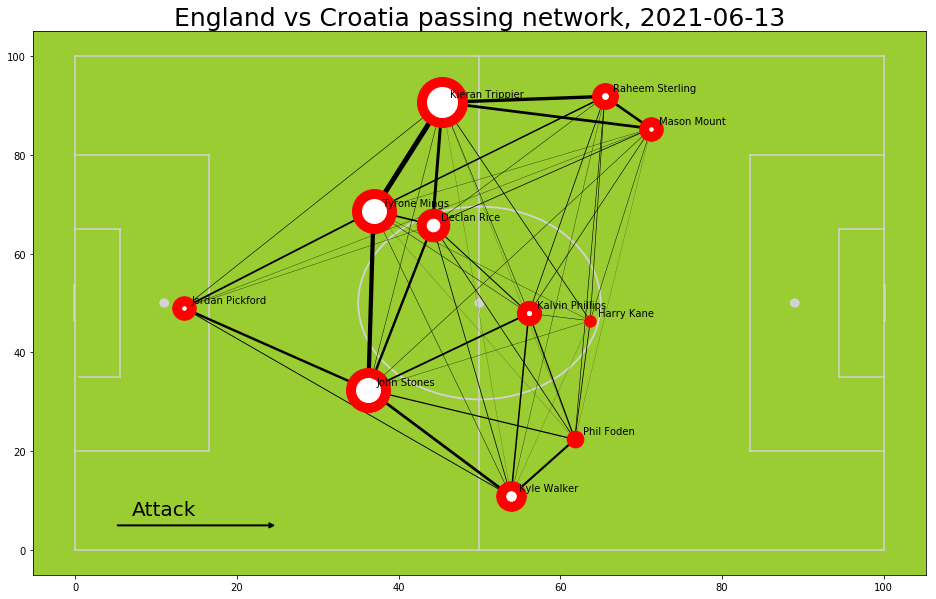

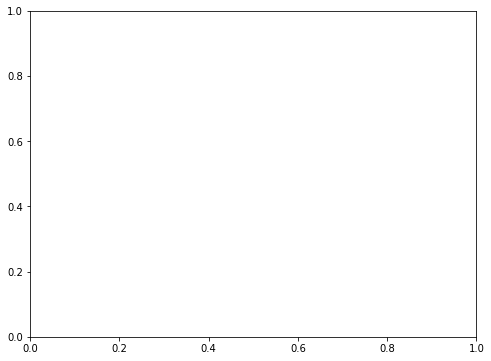

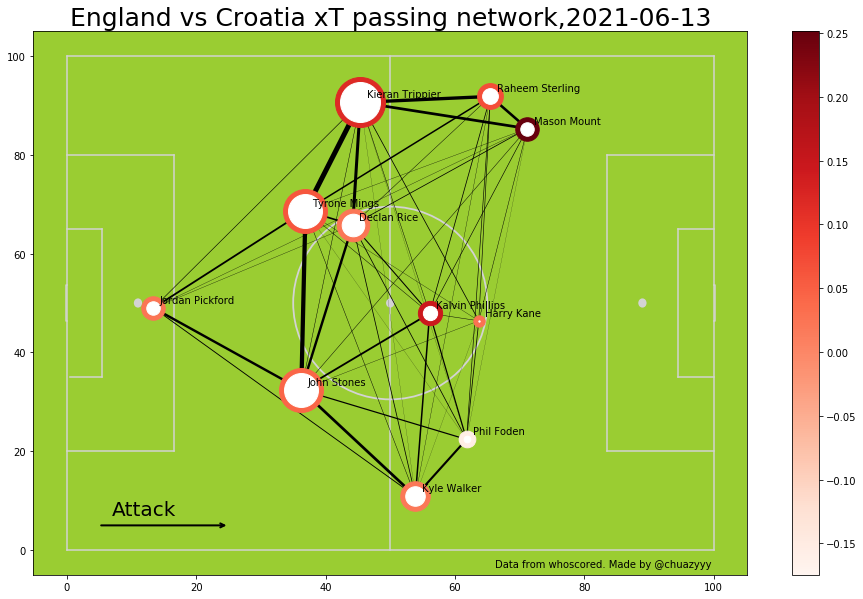

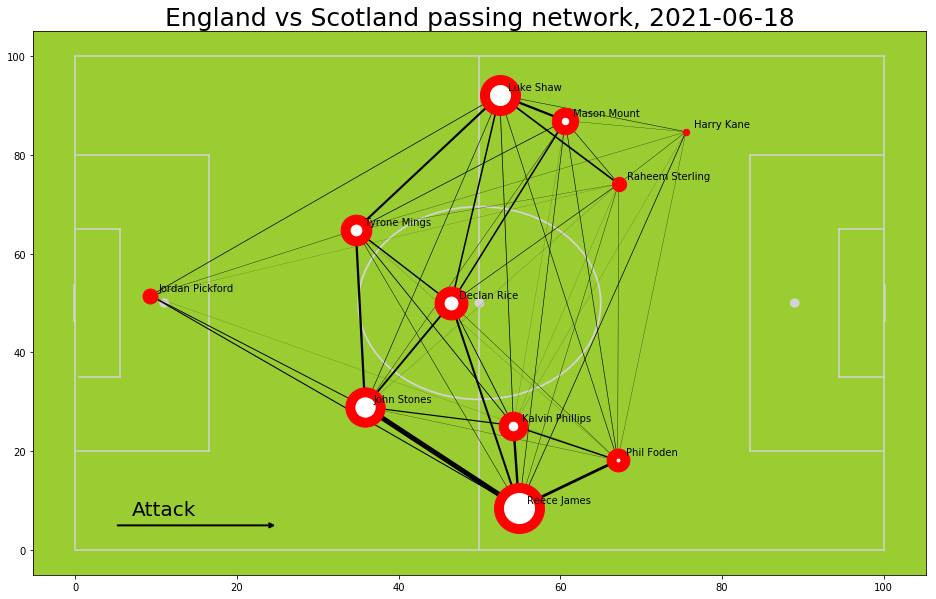

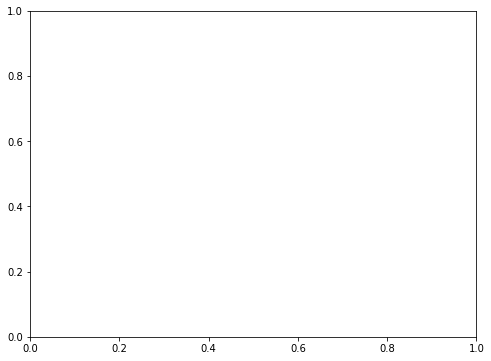

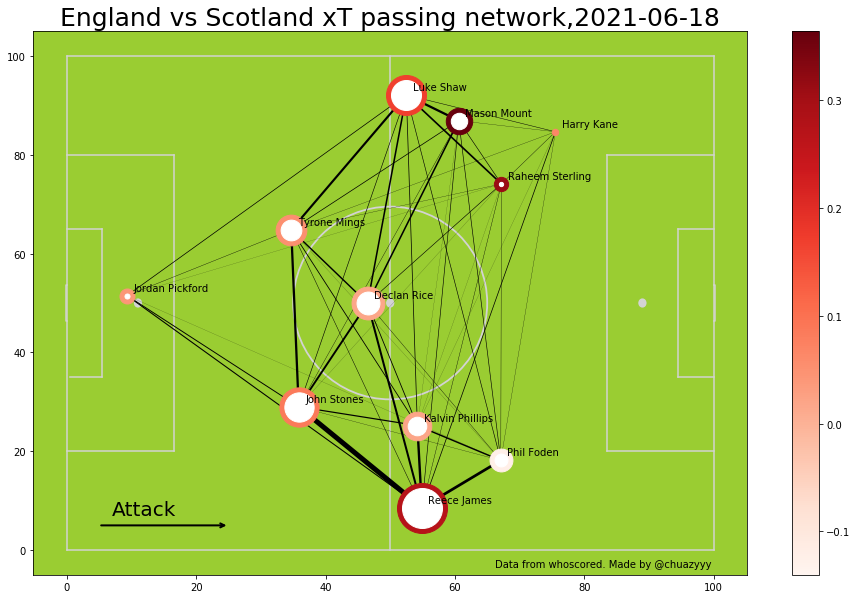

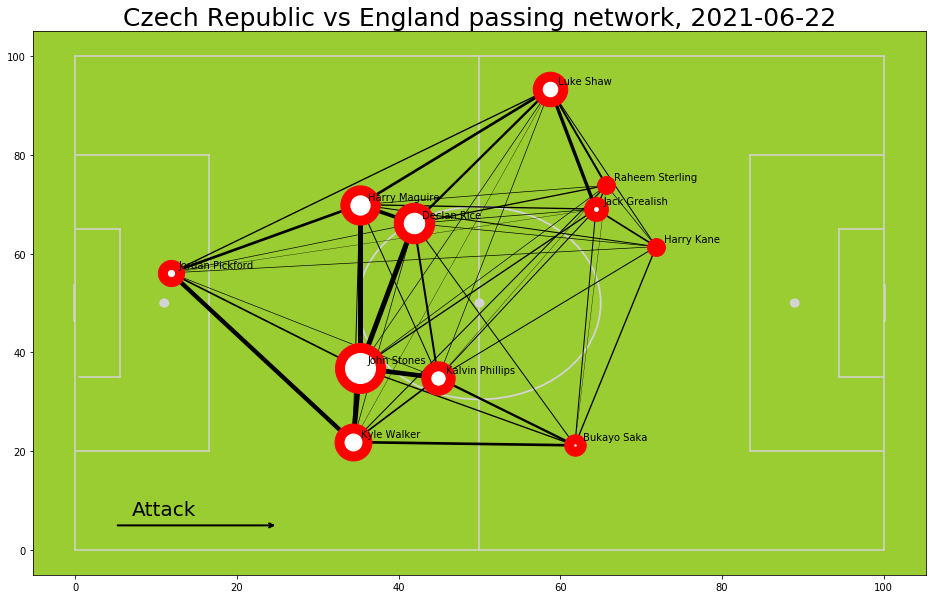

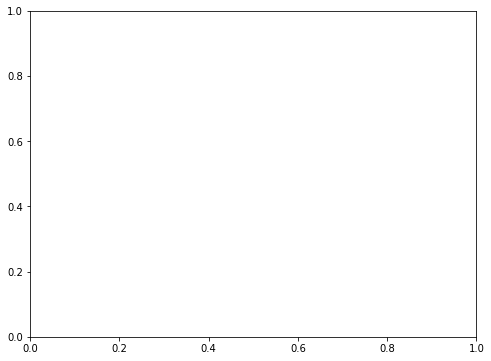

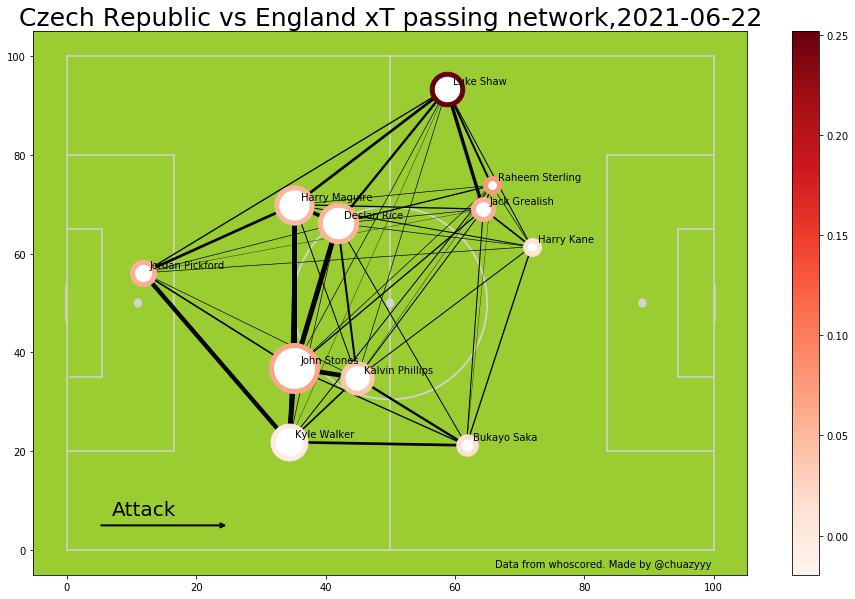

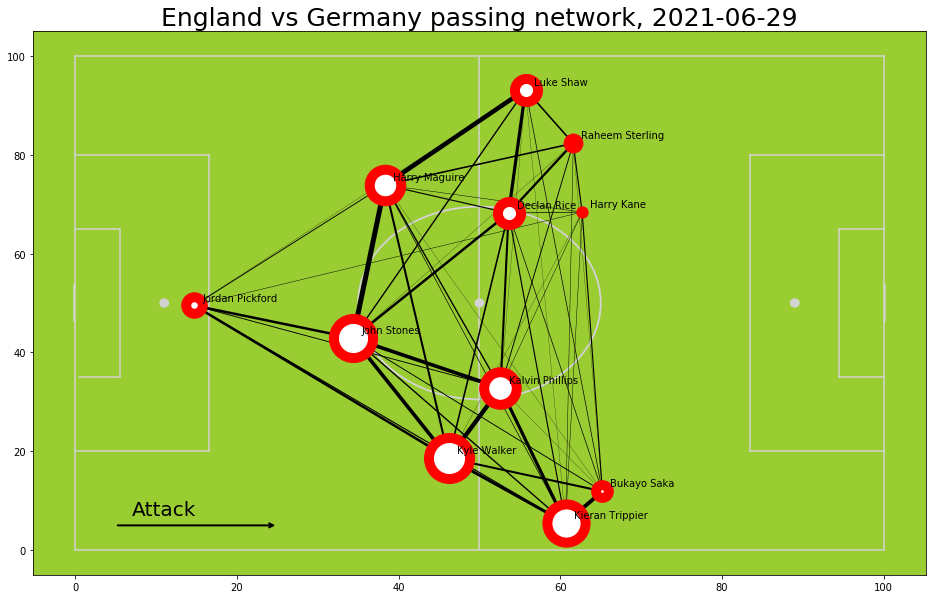

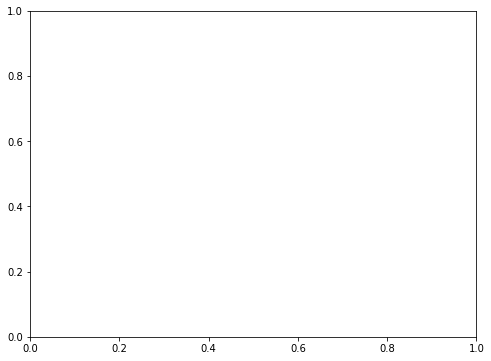

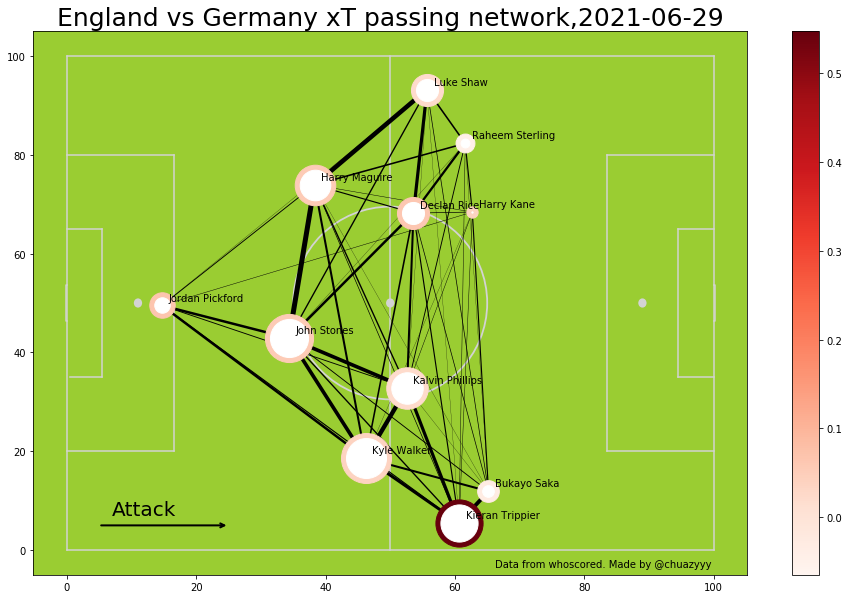

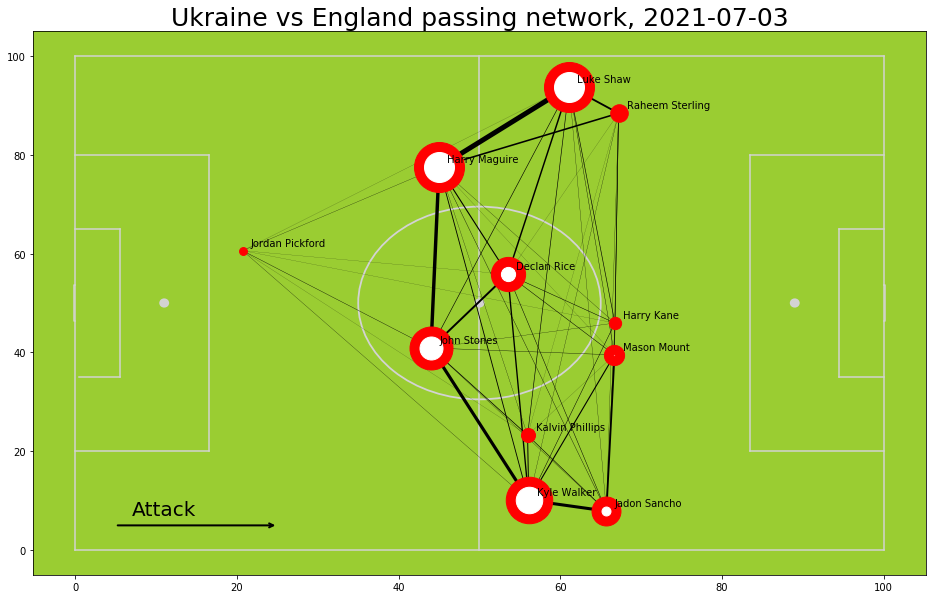

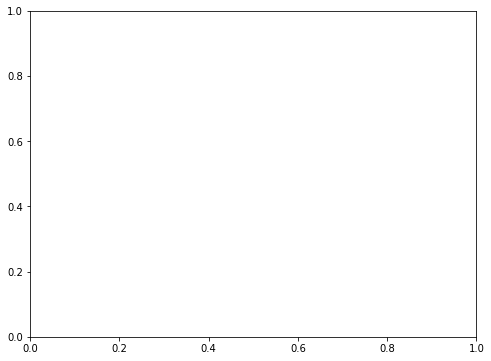

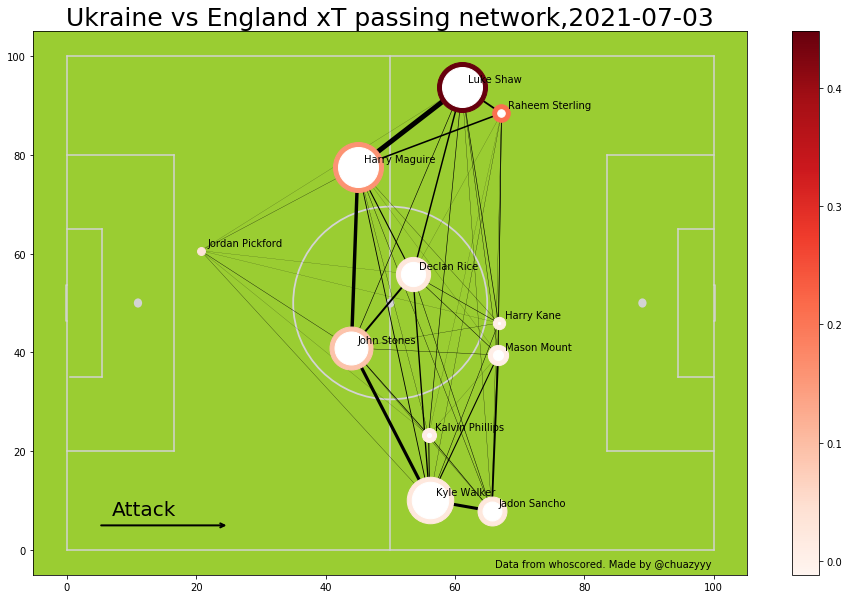

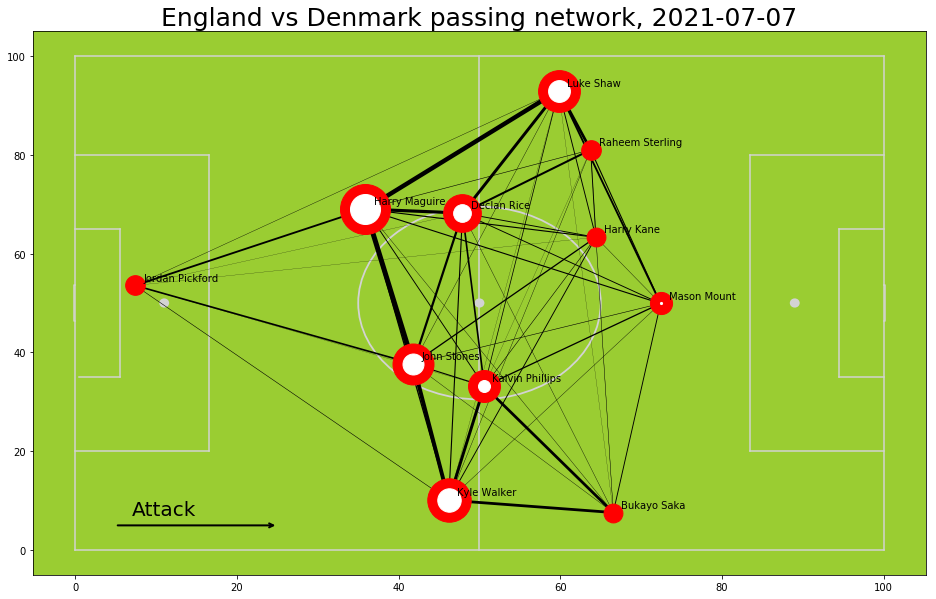

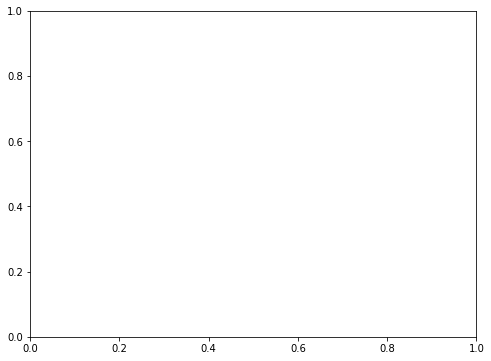

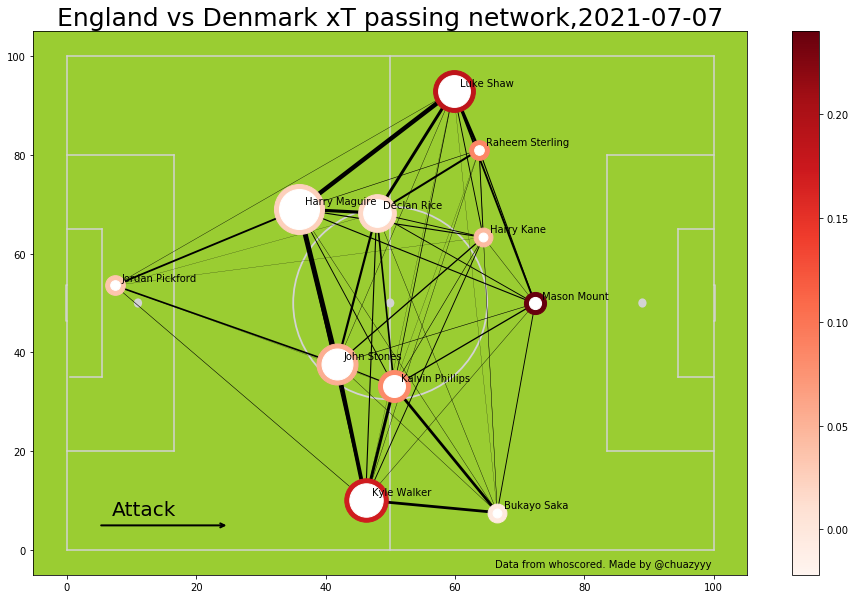

In [16]:
## England
jsonpath = 'xT_2018.json'
ls = ['1434361','1513468','1434363','1553545','1559451','1565600']
team_id = 345
for num in ls:
    df = load_json4(num)
    test_df = cross_map_from_api(df)
    test_3_df = prepare_joined_data()
    max_min = compute_minutes(test_3_df,team_id)
    prepare_passes_data(team_id)
    plot_passing_network()
    data = xT_json(jsonpath)
    player_pass_xT = xT_prep(team_id)
    plot_xT()
    print('This file has been processed %s' %num)
    #with open(os.path.join(path_to_json,js)) as f:
        
    #    matchCentredata = json.load(f)
    # Return the matchCentredata as a dataframe
    #    df = pd.DataFrame(matchCentredata['events'])
    #    print(os.path.join(path_to_json,js))

In [ ]:
## Italy
jsonpath = 'xT_2018.json'
ls = ['1434346','1434349','1434351','1551945','1559075','1563891']
team_id = 343
for num in ls:
    df = load_json4(num)
    test_df = cross_map_from_api(df)
    test_3_df = prepare_joined_data()
    max_min = compute_minutes(test_3_df,team_id)
    prepare_passes_data(team_id)
    plot_passing_network()
    data = xT_json(jsonpath)
    player_pass_xT = xT_prep(team_id)
    plot_xT()
    print('This file has been processed %s' %num)
    #with open(os.path.join(path_to_json,js)) as f:
        
    #    matchCentredata = json.load(f)
    # Return the matchCentredata as a dataframe
    #    df = pd.DataFrame(matchCentredata['events'])
    #    print(os.path.join(path_to_json,js))

In [ ]:
df = load_json4(1434346)

In [ ]:
team_df

In [ ]:
ax.set_title("{0} vs {1} xT passing network,{2}".format(home_team,away_team,date),fontsize=20)


In [ ]:
fig , ax = plt.subplots(1, 1, figsize=(8, 6))

ax = pitch()

min_xT = player_pass_xT['delta_xT'].min()
max_xT = player_pass_xT['delta_xT'].max()

for key, col in pair_pass_df.iterrows():
    Player1, Player2 = key.split('_')
    pair_pass_df.at[key,'Player1'] = Player1
    pair_pass_df.at[key,'Player2'] = Player2
    Player1_x = player_coord.loc[Player1]['x']
    Player1_y = player_coord.loc[Player1]['y']
    Player2_x = player_coord.loc[Player2]['x']
    Player2_y = player_coord.loc[Player2]['y']

    line_width = _convert_range_passes(col['Number of Passes'],max_passes,5)

    #pair_pass_df.at[key,'linewidth'] = line_width
    #print (Player1,Player2,'r-o',line_width)

    ax.plot([Player1_x,Player2_x],[Player1_y,Player2_y],'k-',
            linestyle = '-',lw=line_width, alpha=1,zorder=3, markersize = 15,markerfacecolor = "White")

### Plot the playername as well as the size of the marker depending on number of passes    

for PlayerName, txt in player_pass_xT.iterrows():
    #print(PlayerName, txt['x'], txt['y'])
    marker_size = _convert_range_passes(txt['Total_Player_Passes'],max_player_pass,100)
    norm = Normalize(vmin = min_xT-0.02, vmax= max_xT )
    node_cmap = cm.get_cmap('Reds')
    node_colour = node_cmap(norm(txt['delta_xT']))
    ax.plot(txt['x'], txt['y'],'.',color = node_colour ,markersize = marker_size,zorder =3)
    ax.plot(txt['x'], txt['y'],'.',color = 'white',markersize = marker_size-20,zorder=4)
    ax.annotate(PlayerName, xy =(txt['x']+1, txt['y']+1),zorder=5)
#plt.annotate(playername,xy = (x_coord, y_coord),xytext = (x_coord+1,y_coord+1))

away_team = team_df.iloc[0]['name']
home_team = team_df.iloc[1]['name']
date = team_df.iloc[1]['Start_Date']

sm = plt.cm.ScalarMappable(cmap=node_cmap, norm=Normalize(vmin = min_xT, vmax= max_xT ))
sm._A = []

ax.set_title("{0} vs {1} xT passing network,{2}".format(home_team,away_team,date),fontsize=25)
fig.colorbar(sm,ax=ax)

ax.text(0.95, 0.01, 'Data from whoscored. Made by @chuazyyy',
    verticalalignment='bottom', horizontalalignment='right',
    transform=ax.transAxes,
    color='black', fontsize=10)

In [ ]:
def createGoalMouth():
    #Adopted from FC Python
    #Create figure
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    linecolor='black'

    #Pitch Outline & Centre Line
    plt.plot([0,65],[0,0], color=linecolor)
    plt.plot([65,65],[50,0], color=linecolor)
    plt.plot([0,0],[50,0], color=linecolor)
    
    #Left Penalty Area
    plt.plot([12.5,52.5],[16.5,16.5],color=linecolor)
    plt.plot([52.5,52.5],[16.5,0],color=linecolor)
    plt.plot([12.5,12.5],[0,16.5],color=linecolor)
    
    #Left 6-yard Box
    plt.plot([41.5,41.5],[5.5,0],color=linecolor)
    plt.plot([23.5,41.5],[5.5,5.5],color=linecolor)
    plt.plot([23.5,23.5],[0,5.5],color=linecolor)
    
    #Goal
    plt.plot([41.5-5.34,41.5-5.34],[-2,0],color=linecolor)
    plt.plot([23.5+5.34,41.5-5.34],[-2,-2],color=linecolor)
    plt.plot([23.5+5.34,23.5+5.34],[0,-2],color=linecolor)
    
    #Prepare Circles
    leftPenSpot = plt.Circle((65/2,11),0.8,color=linecolor)
    
    #Draw Circles
    ax.add_patch(leftPenSpot)
    
    #Prepare Arcs
    leftArc = Arc((32.5,11),height=18.3,width=18.3,angle=0,theta1=38,theta2=142,color=linecolor)
    
    #Draw Arcs
    ax.add_patch(leftArc)
    
    #Tidy Axes
    plt.axis('off')
    
    return ax

In [ ]:
createGoalMouth()

In [ ]:
def createGoalMouth2():
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    linecolor='black'

    #Pitch Outline & Centre Line
    plt.plot([0,50],[50,50], color=linecolor)
    plt.plot([50,50],[50,0], color=linecolor)
    plt.plot([0,0],[50,0], color=linecolor)

    #Left Penalty Area
    plt.plot([40,10],[33.5,33.5],color=linecolor)
    plt.plot([10,10],[33.5,50],color=linecolor)
    plt.plot([40,40],[50,33.5],color=linecolor)

    # plt.plot([16.5,16.5],[80,20],color="lightgrey")
    # plt.plot([0,16.5],[80,80],color="lightgrey")
    # plt.plot([16.5,0],[20,20],color="lightgrey")

    #Left 6-yard Box
    plt.plot([32.5,32.5],[46.5,50],color=linecolor)
    plt.plot([32.5,17.5],[46.5,46.5],color=linecolor)
    plt.plot([17.5,17.5],[50,46.5],color=linecolor)

    # plt.plot([0,5.5],[65,65],color="lightgrey")
    # plt.plot([5.5,5.5],[65,35],color="lightgrey")
    # plt.plot([5.5,0.5],[35,35],color="lightgrey")

    #Goal
    plt.plot([32.5-3.66,32.5-3.66],[52,50],color=linecolor)
    plt.plot([17.5+3.66,32.5-3.66],[52,52],color=linecolor)
    plt.plot([17.5+3.66,17.5+3.66],[50,52],color=linecolor)

    #Prepare Circles
    leftPenSpot = plt.Circle((50/2,39),0.8,color=linecolor)

    #Draw Circles
    ax.add_patch(leftPenSpot)

    #Prepare Arcs
    #leftArc = Arc((25,11),height=18.3,width=18.3,angle=0,theta1=38,theta2=142,color=linecolor)
    leftArc2 = Arc((25,39),height=15,width=15,angle=0,theta1=230,theta2=310,color=linecolor)

    #Draw Arcs
    #ax.add_patch(leftArc)
    ax.add_patch(leftArc2)
    
    
    #Tidy Axes
    plt.axis('off')
    
    ax.set_facecolor('yellowgreen')

    
    return fig, ax

In [ ]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

linecolor='black'

#Pitch Outline & Centre Line
plt.plot([0,50],[50,50], color=linecolor)
plt.plot([50,50],[50,0], color=linecolor)
plt.plot([0,0],[50,0], color=linecolor)

#Left Penalty Area
plt.plot([40,10],[33.5,33.5],color=linecolor)
plt.plot([10,10],[33.5,50],color=linecolor)
plt.plot([40,40],[50,33.5],color=linecolor)

# plt.plot([16.5,16.5],[80,20],color="lightgrey")
# plt.plot([0,16.5],[80,80],color="lightgrey")
# plt.plot([16.5,0],[20,20],color="lightgrey")

#Left 6-yard Box
plt.plot([32.5,32.5],[46.5,50],color=linecolor)
plt.plot([32.5,17.5],[46.5,46.5],color=linecolor)
plt.plot([17.5,17.5],[50,46.5],color=linecolor)

# plt.plot([0,5.5],[65,65],color="lightgrey")
# plt.plot([5.5,5.5],[65,35],color="lightgrey")
# plt.plot([5.5,0.5],[35,35],color="lightgrey")

#Goal
plt.plot([32.5-3.66,32.5-3.66],[52,50],color=linecolor)
plt.plot([17.5+3.66,32.5-3.66],[52,52],color=linecolor)
plt.plot([17.5+3.66,17.5+3.66],[50,52],color=linecolor)

#Prepare Circles
leftPenSpot = plt.Circle((50/2,39),0.8,color=linecolor)

#Draw Circles
ax.add_patch(leftPenSpot)

#Prepare Arcs
#leftArc = Arc((25,11),height=18.3,width=18.3,angle=0,theta1=38,theta2=142,color=linecolor)
leftArc2 = Arc((25,39),height=15,width=15,angle=0,theta1=230,theta2=310,color=linecolor)

#Draw Arcs
#ax.add_patch(leftArc)
ax.add_patch(leftArc2)

ax.set_facecolor('yellowgreen')
#Tidy Axes
plt.axis('on')

In [ ]:
createGoalMouth2()


In [ ]:
type_df = pd.concat([pd.DataFrame(json_normalize(x)) for x in df['type']],ignore_index=True)
type_df.columns = ['actionType_value','actionType_displayName']
#type_df.columns = ['idx','len','type_displayName','type_value']


In [ ]:
type_df

In [ ]:
#Create new_df

new_df = df.join(outcome_df.join(type_df[['displayName','value']]))

## Rename

new_df = new_df.rename(columns={'displayName':'type_displayName',
                   'value':'type_value'})

In [ ]:
new_df['type_displayName'].unique()

In [ ]:
test_df[test_df['isShot']==True]['type_displayName'].unique()

In [ ]:
def plot_shots(team_id,test_df):
    for index, rows in test_df.iterrows():
        if rows['type_displayName'] in ('MissedShots','ShotOnPost'):
            #print('Shot off Target')
            test_df.at[index,'Shotoutcome'] = 'Shot off Target'
        elif rows['type_displayName'] == 'SavedShot':
            test_df.at[index,'Shotoutcome'] = 'Shot on Target'
        elif rows['type_displayName'] == 'Goal':
            test_df.at[index,'Shotoutcome'] = 'Goal'
            
    shots_df = test_df.query('teamId == %s'%team_id)
    shots_df = shots_df[shots_df['period_displayName']!='PenaltyShootout']
    
    return shots_df
            
    

In [ ]:
test_df.groupby('Shotoutcome').count()

In [ ]:
for index, rows in test_df.iterrows():
        if rows['type_displayName'] in ('MissedShots','ShotOnPost'):
            print('Shot off Target')
            test_df.at[index,'Shotoutcome'] = 'Shot off Target'
        elif rows['type_displayName'] == 'SavedShot':
            test_df.at[index,'Shotoutcome'] = 'Shot on Target'
        elif rows['type_displayName'] == 'Goal':
            test_df.at[index,'Shotoutcome'] = 'Goal'
            print('Goal')
        else:
            print('Not shot')

shots_df = test_df.query('teamId == %s'%team_id)
shots_df = shots_df[shots_df['period_displayName']!='PenaltyShootout']

In [ ]:
total_shot_df.append(shots_df,ignore_index=True)

In [ ]:
total_shot_df = pd.DataFrame()

In [ ]:
fig , ax = plt.subplots(1, 1, figsize=(8, 6))
ax = pitch()
x_off_target = shots_df[shots_df['Shotoutcome']=='Shot off Target'].x
y_off_target = shots_df[shots_df['Shotoutcome']=='Shot off Target'].y
ax.scatter(x_off_target,y_off_target,facecolors='none', edgecolors='r')
x_on_target = shots_df[shots_df['Shotoutcome']=='Shot on Target'].x
y_on_target = shots_df[shots_df['Shotoutcome']=='Shot on Target'].y
ax.scatter(x_on_target,y_on_target, edgecolors='r',facecolors='r',zorder=2)
x_goal = shots_df[shots_df['Shotoutcome']=='Goal'].x
y_goal = shots_df[shots_df['Shotoutcome']=='Goal'].y
ax.scatter(x_goal,y_goal, edgecolors='k',facecolors='k',zorder=2)

In [ ]:
period_df = pd.concat([pd.DataFrame(json_normalize(x)) for x in shots_df['period']],ignore_index=True)
period_df.columns = ['period_value','period_displayName']  
shots_df = shots_df.join(period_df)
    #type_df = pd.concat([pd.DataFrame(json_normalize(x)) for x in df['type']],ignore_index=True)
    #type_df.columns = ['idx','len','type_displayName','type_value'] 
    
    #Create new_df
    
    #shots_df = shots_df.join(period_df)

In [ ]:
shots_df[shots_df['Shotoutcome']=='Goal']

In [ ]:
shots_df = shots_df.join(period_df)


In [ ]:
shots_df = shots_df[shots_df['period_displayName']!='PenaltyShootout']

In [ ]:
shots_df

In [ ]:
shots_df[shots_df['Shotoutcome']=='Goal']

In [ ]:
shots_df

In [ ]:
shots_df = test_df.query('teamId == %s'%team_id)


In [ ]:
period_df = pd.concat([pd.DataFrame(json_normalize(x)) for x in shots_df['period']],ignore_index=True)
period_df.columns = ['period_value','period_displayName']  

In [ ]:
period_df

In [ ]:
period_df = pd.concat([pd.DataFrame(json_normalize(x)) for x in df['period']],ignore_index=True)
period_df.columns = ['period_value','period_displayName']  
new_df.join(period_df)

In [ ]:
## Italy
jsonpath = 'xT_2018.json'
ls = ['1434346','1434349','1434351','1551945','1559075','1563891']
team_id = 343
total_shot_df = pd.DataFrame([])
for num in ls:
    df = load_json4(num)
    test_df = cross_map_from_api(df)
    shots_df = plot_shots(team_id,test_df)
    total_shot_df = total_shot_df.append(shots_df,ignore_index=True)
    print('This file has been processed %s' %num)
   
        
    #    matchCentredata = json.load(f)
    # Return the matchCentredata as a dataframe
    #    df = pd.DataFrame(matchCentredata['events'])
    #    print(os.path.join(path_to_json,js))

In [ ]:
fig , ax = plt.subplots(1, 1, figsize=(8, 6))
ax = pitch()
x_off_target = total_shot_df[total_shot_df['Shotoutcome']=='Shot off Target'].x
y_off_target = total_shot_df[total_shot_df['Shotoutcome']=='Shot off Target'].y
ax.scatter(x_off_target,y_off_target,facecolors='none', edgecolors='r')
x_on_target = total_shot_df[total_shot_df['Shotoutcome']=='Shot on Target'].x
y_on_target = total_shot_df[total_shot_df['Shotoutcome']=='Shot on Target'].y
ax.scatter(x_on_target,y_on_target, edgecolors='r',facecolors='r',zorder=2)
x_goal = total_shot_df[total_shot_df['Shotoutcome']=='Goal'].x
y_goal = total_shot_df[total_shot_df['Shotoutcome']=='Goal'].y
ax.scatter(x_goal,y_goal, edgecolors='k',facecolors='k',zorder=2)

In [ ]:
#fig , ax = plt.subplots(1, 1, figsize=(8, 6))
fig, ax = createGoalMouth2()
x_off_target = total_shot_df[total_shot_df['Shotoutcome']=='Shot off Target'].x-50 
y_off_target = total_shot_df[total_shot_df['Shotoutcome']=='Shot off Target'].y/2 
shot_off_scatter = ax.scatter(y_off_target,x_off_target,facecolors='none', edgecolors='r')
x_on_target = total_shot_df[total_shot_df['Shotoutcome']=='Shot on Target'].x-50 
y_on_target = total_shot_df[total_shot_df['Shotoutcome']=='Shot on Target'].y/2 
shot_on_scatter = ax.scatter(y_on_target,x_on_target, edgecolors='r',facecolors='r',zorder=2)
x_goal = total_shot_df[total_shot_df['Shotoutcome']=='Goal'].x-50 
y_goal = total_shot_df[total_shot_df['Shotoutcome']=='Goal'].y/2 
goal_scatter = ax.scatter(y_goal,x_goal, edgecolors='k',facecolors='k',zorder=2)

plt.legend((shot_off_scatter, shot_on_scatter, goal_scatter),
           ('Shot off target', 'Shot on Target', 'Goal'),
           scatterpoints=1,
           loc='lower center',
           ncol=3,
           fontsize=8)

ax.set_title("England's shot distribution",fontsize=15)


fig.savefig('plots/Passing_network_plots/euros_2020/England_shot_dist.png',bbox_inches='tight')

In [ ]:
createGoalMouth2()


In [ ]:
total_shot_df[total_shot_df['Shotoutcome']=='Shot off Target']

In [ ]:
## England
jsonpath = 'xT_2018.json'
ls = ['1434361','1513468','1434363','1553545','1559451','1565600']
team_id = 345
total_shot_df = pd.DataFrame([])
for num in ls:
    df = load_json4(num)
    test_df = cross_map_from_api(df)
    shots_df = plot_shots(team_id,test_df)
    total_shot_df = total_shot_df.append(shots_df,ignore_index=True)
    print('This file has been processed %s' %num)
   